TypeError: can't multiply sequence by non-int of type 'float'

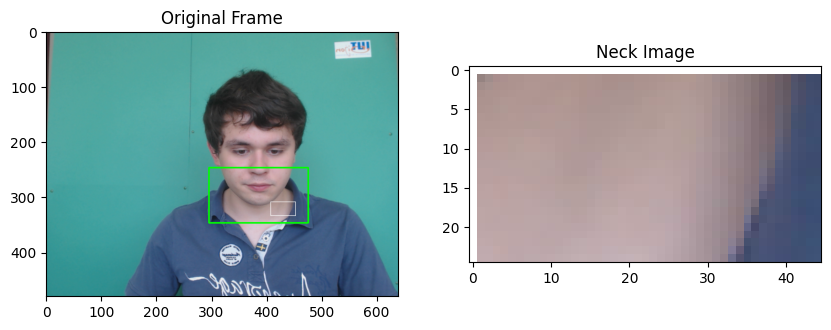

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import butter, filtfilt, find_peaks

class FaceDetect:
    def __init__(self, video_path=None, sav_opt=0, filename=[]):
        self.video_path = video_path
        self.face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_default.xml")
        self.eye_cascade = cv2.CascadeClassifier("./haarcascade_eye.xml")
        self.cap = cv2.VideoCapture(self.video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.sav_opt = sav_opt  
        self.filename = filename
        self.cheek = []

    def butter_lowpass(self, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(self, data, cutoff, fs, order=5):
        b, a = self.butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        return y
        
    def butter_bandpass(self, lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=5):
        b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y

    def run_vid(self):
        cropmn = []
        frame_count = 0        
        i = 0
        pixel_values = []
        time_values = []
        red = []
        green = []
        blue = []
        
        while frame_count < int(30 * self.fps): #control the time that spend for reading
            ret, frame = self.cap.read()
            if not ret:
                break
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #gray=cv2.cvtColor
            # face detection with face_cascade
            faces = self.face_cascade.detectMultiScale(
                    gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize = (30,30),
                    flags = cv2.CASCADE_SCALE_IMAGE
                    )

            for (x, y, w, h) in faces:
                new_rect_x = x   # 얼굴 영역 오른쪽으로 20픽셀 이동
                new_rect_y = y + 100 # 얼굴 영역과 같은 높이에서 시작
                new_rect_w = w  # 새 사각형의 너비
                new_rect_h = 100  # 새 사각형의 높이
                # 새로운 사각형을 그립니다.
                cv2.rectangle(frame, (new_rect_x, new_rect_y), (new_rect_x + new_rect_w, new_rect_y + new_rect_h), (0, 255, 0), 2)
                face_image = frame[new_rect_y:new_rect_y + new_rect_h, new_rect_x:new_rect_x + new_rect_w]
                cv2.imshow("Detected face", face_image)
                
                
                [a, b, c, d] = [5 * new_rect_w // 8, 5 *new_rect_h // 8, 7 * new_rect_w // 8, 7 * new_rect_h // 8]  #space that I assigned
                cv2.rectangle(face_image, (a, b), (c, d), (255, 255, 255))
                neckimg = face_image[b:d, a:c]
                cv2.imshow("neckimg ", neckimg)
                
                self.cheek.append(neckimg.mean()) 

                # Calculate the center point of the neckimg rectangle by the facial mask
                center_x = 35 * w // 50  # Calculate center x
                center_y = 25 * h // 60  # Calculate center y
            
                # Extract a 7x7 region around the center point
                roi_size = 3  # Half-size of the ROI, 7x7 requires 3 pixels around the center
                roi = face_image[max(center_y - roi_size, 0):min(center_y + roi_size + 1, face_image.shape[0]),
                                 max(center_x - roi_size, 0):min(center_x + roi_size + 1, face_image.shape[1])]
            
                # Calculate average color values in the ROI
                avg_color_per_row = np.average(roi, axis=0)
                avg_color = np.average(avg_color_per_row, axis=0)
                avg_red, avg_green, avg_blue = avg_color[2], avg_color[1], avg_color[0]
            
                # Append the average values to the lists
                red.append(avg_red)
                green.append(avg_green)
                blue.append(avg_blue)
    
                # Get the pixel value at the center point
                pixel_value = face_image[center_y, center_x]  # Access pixel value
                # Append the pixel value to the list
                pixel_values.append(pixel_value)
                
                if i < len(self.cheek):
                    time_values.append(frame_count / self.fps)
                    red.append(face_image[center_y, center_x][2])  # Red channel
                    green.append(face_image[center_y, center_x][1])  # Green channel
                    blue.append(face_image[center_y, center_x][0])  # Blue channel
                    
                if frame_count == 1:
                    plt.figure(figsize=(10, 5))
                    
                    plt.subplot(1, 2, 1)
                    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    plt.title('Original Frame')
            
            
                    plt.subplot(1, 2, 2 )
                    plt.imshow(cv2.cvtColor(neckimg, cv2.COLOR_BGR2RGB))
                    plt.title('Neck Image')
                    
                else :
                    break

            # Display the result
            if cv2.waitKey(1) & 0xFF == 27 :
                break
                    
            frame_count += 1
            i += 1
            time_values.append(frame_count / self.fps)
    
        cv2.destroyAllWindows()
        self.cheek = np.array(self.cheek)
        
        #raw data
        org_combined = (0.3 * red) + (1 * green) + (0.3 * blue)
        peaks, _ = find_peaks(org_combined)
        org_intervals = np.diff(peaks) / self.fps
        print("intervals", org_intervals)
        org_check_heart = 60 / org_intervals
        print('heart rate per minite', org_check_heart)
        
        
        
        # band-pass filter            
        filtered_red = self.butter_bandpass_filter(red, 0.5, 3.0, self.fps)
        filtered_green = self.butter_bandpass_filter(green, 0.5, 3.0, self.fps)
        filtered_blue = self.butter_bandpass_filter(blue, 0.5, 3.0, self.fps)
        
        # low-pass filter
        lowpass_cutoff = 2.5  # cutoff frequency (Hz)
        lowpassed_red = self.butter_lowpass_filter(filtered_red, lowpass_cutoff, self.fps)
        lowpassed_green = self.butter_lowpass_filter(filtered_green, lowpass_cutoff, self.fps)
        lowpassed_blue = self.butter_lowpass_filter(filtered_blue, lowpass_cutoff, self.fps)

        # Bandpass+low-pass filtered RGB
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(time_values, lowpassed_red, label='Band-pass+Low-passed Red', color='r')
        plt.plot(time_values, lowpassed_green, label='Band-pass+Low-passed Green', color='g')
        plt.plot(time_values, lowpassed_blue, label='Band-pass+Low-passed Blue', color='b')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pixel Value')
        plt.title('Bandpass and Low-pass Filtered RGB Channels Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
        #filter finished
        
        #calculate HR with peak data (give more weight to Green chanel) 
        combined_signal = (0.3 * lowpassed_red) + (1 * lowpassed_green) + (0.3 * lowpassed_blue)
        peaks, _ = find_peaks(combined_signal)
        intervals = np.diff(peaks) / self.fps
        print("intervals", intervals)
        check_heart = 60 / intervals
        print('heart rate per minite', check_heart)

        #average HR
        if len(intervals) > 0:
            avg_heart_rate = 60 / np.mean(intervals)
        else:
            avg_heart_rate = 0  # if there's no peak
        print("vidname : ", vidname)
        print(f"Average Estimated Heart Rate: {avg_heart_rate} BPM")

        if self.sav_opt:
            self.vidwrit(i2s=self.cheek)

        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 2)
        plt.plot(time_values, combined_signal, label='Combined Signal', color='purple')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pixel Value')
        plt.title('Combined RGB Channels Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()  
        #HR detection finished
        
        #지금 현재 5-10초 동안의 그래프 확인 
        # Plot filtered RGB channels over the specific time interval
        start_time = 15  # Start time in seconds
        end_time = 30    # End time in seconds
        start_index = int(start_time * self.fps)
        end_index = int(end_time * self.fps)
    
        # Ensure indices are within the array bounds
        start_index = min(start_index, len(filtered_red) - 1)
        end_index = min(end_index, len(filtered_red))
    
        # Extracting slices for the specified time interval
        time_slice = time_values[start_index:end_index]
        red_slice = lowpassed_red[start_index:end_index]
        green_slice = lowpassed_green[start_index:end_index]
        blue_slice = lowpassed_blue[start_index:end_index]
    
        # Plotting the sliced data
        plt.figure(figsize=(10, 6))
        #plt.subplot(1, 1, 1)
        plt.plot(time_slice, red_slice, label='Red', color='r')
        plt.plot(time_slice, green_slice, label='Green', color='g')
        plt.plot(time_slice, blue_slice, label='Blue', color='b')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Filtered Pixel Value')
        plt.title('Filtered RGB Channels (Interval)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        limited_combined_signal = combined_signal[start_index:end_index]
        #graph for combined_signal        
        plt.figure(figsize=(10, 6))
        #plt.subplot(1, 1, 2)
        plt.plot(time_slice, limited_combined_signal, label='Combined Signal', color='purple')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pixel Value')
        plt.title('Limited Combined RGB Channels Over Time')
        plt.legend()
        plt.grid(True)
        plt.show() 

        return avg_heart_rate, self.cheek, pixel_values, red, blue, green

    def vidwrit(self, i2s=[]):
        out = cv2.VideoWriter(self.filename, cv2.VideoWriter_fourcc(*'DIVX'), self.fps, (200, 200))
        for i in range(len(i2s)):
            out.write(i2s[i])
        out.release()
    
#call the vid
vidname = './vid-10.avi'
cap = cv2.VideoCapture(vidname)
videop =  FaceDetect(video_path=vidname, sav_opt=0, filename=vidname)

avg_heart_rate, _, _, _, _, _ = videop.run_vid()

cap.release()
cv2.destroyAllWindows()